# Predicting Missing Fitbit Data

## Summary of Findings

---
## Project Plan

### Goals
 - Predict missing values from the data set using clustering
 - Derive insights on "Armstrong", the person from whom the fitness data was generated

### Hypotheses
 - There are patterns on Armstrong's daily activities.
 - Armstrong's fitness activity is affected by the month/season of the year.

### Data Science Skills Used
 - Data prep and cleaning
 - Time Series Analysis
 - Visualization
 - Modeling using Parametric Methods
 - Modeling using the Prophet algorithm
 - Evaluation of Models

---
## Data Dictionary

---
## Notes on the Fitbit Data:

We are given eight .csv files that hold monthly data of an individual, whom we elect to call "Armstrong". Before we begin wrangling the data, we peruse all the files and made initial notes as follows:

1. The "missing" data is from 6/27/2018 - 7/6/2018 on the following variables:
  - Steps
  - Distance
  - Floors
  - Lightly Active in Minutes
  - Fairly Active in Minutes
  - Very Active in Minutes
2. Food/ Food log data is almost empty. There are only 1 record available in May-June data, and 7 records in the October-November data.
3. The data range covers April 26, 2018 to December 6, 2018.

### Packages

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from sklearn import metrics


import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warning
import warnings
warnings.filterwarnings("ignore")

# project_specific modules
import acquire
import model

## I. Acquire and Preprocess

### A. Acquire

We manipulated the individual csv files from Excel, and decided to create a single .csv file as the size of the data is manageable. We only wanted the activity data, and not the food/food log data which barely contain any data.

`act.csv` is the csv file that integrates all relevant activitiy data from the eight .csv files provided.

`get_activity` function from the acquire.py module produces a data frame out of `act.csv` and renames the columns for efficiency.

In [2]:
df = acquire.get_activity()

Look at data and see if there are nulls and inappropriate data types.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                 225 non-null object
cal_burn             225 non-null object
steps                225 non-null object
distance             225 non-null float64
floors               225 non-null int64
min_sed              225 non-null object
min_active_light     225 non-null int64
min_active_fairly    225 non-null int64
min_active_very      225 non-null int64
cal_activity         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


- There are no nulls in the data set.
- Apart from `date` which will be handled later, there are four columns that are object type, namely.
  - cal_burn
  - steps
  - min_sed
  - cal_activity

In [4]:
df.sample(5) #inspect the object-type attributes, why are they being read as string/object?

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
65,6/30/18,"2,145",0,0.00,0,"1,440",0,0,0,0
100,8/4/18,"4,376","17,126",8.08,78,585,206,17,124,"2,584"
118,8/22/18,"3,811","8,678",4.09,5,845,200,13,48,"1,852"
17,5/13/18,"2,572","1,689",0.80,0,895,84,0,0,394
9,5/5/18,"2,551",833,0.39,0,969,68,0,0,326


It seems that commas are making these numeric attributes as object types. To remove commas and cast these columns from object into integer types, call the `handle_obj_type` function from the acquire.py module.

In [5]:
df = acquire.handle_obj_type(df)

### B. Split Data

Split the data into train and test using the `split_activity` from the acquire module.
  
Train = 70%  (Beginning to September 29,2018)  
Test = 30% (September 30,2018 to End)

In [6]:
train, test = acquire.split_activity(df, train_prop=.7)

### C. Set Date as Index 

To facilitate our analysis, cast `date` column into datetime data type, and set it as the index of our data frame. Call `set_date_as_index` function to execute these.

In [7]:
train = acquire.set_date_as_index(train)
test = acquire.set_date_as_index(test)

## II. Impute Missing Data

Basal Metabolic Rate (BMR) is defined as the rate at which your body uses energy when you are resting in order to keep vital functions going such as breathing and staying warm.

BMR is the difference between the calories that are burned and the calories expended during activity.

Knowing Armstrong's average BMR (which is a relative constant for him as an individual) informs us of how we can impute one attribute `cal_activity` that contain missing data. We will use this formula to derive values for `cal_activity`.

$BMR$ = $\mu_{cal\_burn - cal\_activity}$

The plot below confirms the interdependence of `cal_activity` and `cal_burn`.

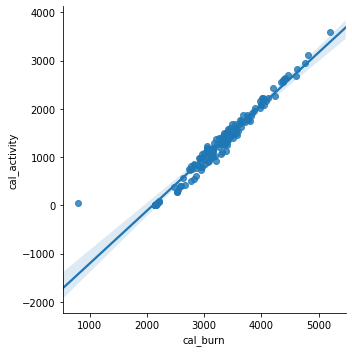

In [8]:
sns.lmplot(data=train,x="cal_burn",y="cal_activity")

### A. Impute `cal_activity` using BMR

Process:
1. Get median_bmr to get Armstrong's constant BMR.
2. Subset the week with missing values and zero in on the `cal_activity`.
3. If `cal_activity` = 0, impute calculated `cal_activity` using the formula. Otherwise, use the true `cal_activity` value.

In [9]:
median_bmr = (train.cal_burn - train.cal_activity).median()
print(f"Armstrong's Median BMR is: {median_bmr}")

Armstrong's Median BMR is: 1986.0


Add a column in train with a computed `cal_activity` based on formula.

In [10]:
train["calculated_cal_activity"] = train.cal_burn - median_bmr

Subset the days with missing values

In [11]:
missing_subset = train["2018-06-26":"2018-07-06"]

Use `np.where` to replace 0 with calculated cal_activity, and retain actual values if not 0.

In [12]:
missing_subset["cal_activity"] = np.where(missing_subset.cal_activity == 0, missing_subset.calculated_cal_activity, missing_subset.cal_activity)

Attach the subset back to train.

In [13]:
train.loc["2018-06-26":"2018-07-06","cal_activity"] = missing_subset.cal_activity

In [14]:
train["2018-06-26":"2018-07-06"] #Check if we have successfully imputed cal_activity

,index,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,calculated_cal_activity
date,,,,,,,,,,,
2018-06-26,61,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-06-27,62,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-28,63,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-29,64,2180,0,0.00,0,1437,3,0,0,39.0,194.0
2018-06-30,65,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-07-01,66,3090,4714,2.22,4,1005,232,0,0,1125.0,1104.0
2018-07-02,67,2204,172,0.08,0,1024,12,0,0,67.0,218.0
2018-07-03,68,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-07-04,69,2183,0,0.00,0,1438,2,0,0,42.0,197.0


### B. Impute the Rest of the Missing Data

We still have other missing data from the following attributes:
- `steps`
- `distance`
- `floors`
- `min_active_light`
- `min_active_fairly`
- `min_active_very`

Unlike the `cal_activity` with heavy interdependence with known values in `cal_burn` (i.e., using BMR), the attributes above can be calculated using the mean of observations with similar daily profile to the ones missing.

The days with missing values is what we loosely described as "Lazy Days" where the `cal_burn` and `cal_activity` values are below the median. Specifically, the days with missing values have cal_burn of 2000-2500, when the median `cal_burn` is 3302.5 in train.

Armstrong was generally "lazy" on the days that we lost the data from!

With these in mind, we decide the imputation process to be as follows:
 1. Find similar-looking "Lazy Days" observations.
 2. Limit the observations with similar-looking "Lazy Days", that is, with `cal_burn` between 2000-2500.
 3. Get the mean values of attributes of "Lazy Days". These values are going to be the imputed constants for our missing values.
 5. Excluding values from July 1 and 2, 2018 which contain true values, impute the mean constants.

In [15]:
#Steps Mean Constant
mean_lds_steps = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].steps.mean()

#Distance Mean Constant
mean_lds_distance = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].distance.mean()

#Floors Mean Constant
mean_lds_floor = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].floors.mean()

#Lightly Active Minutes Mean Constant
mean_lds_light = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_light.mean()

#Fairly Active Minutes Mean Constant
mean_lds_fairly = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_fairly.mean()

#Very Active Minutes Mean Constant
mean_lds_very = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_very.mean()

In [16]:
missing_subset_21 = train["2018-06-26":"2018-06-30"]
missing_subset_22 = train["2018-07-03":"2018-07-06"]

In [17]:
missing_subset_21["steps"] = mean_lds_steps
missing_subset_21["distance"] = mean_lds_steps
missing_subset_21["floors"] = mean_lds_steps
missing_subset_21["min_active_light"] = mean_lds_light
missing_subset_21["min_active_fairly"] = mean_lds_fairly
missing_subset_21["min_active_very"] = mean_lds_very

In [18]:
missing_subset_22["steps"] = mean_lds_steps
missing_subset_22["distance"] = mean_lds_steps
missing_subset_22["floors"] = mean_lds_steps
missing_subset_22["min_active_light"] = mean_lds_light
missing_subset_22["min_active_fairly"] = mean_lds_fairly
missing_subset_22["min_active_very"] = mean_lds_very

In [19]:
missing_subset_22

,index,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,calculated_cal_activity
date,,,,,,,,,,,
2018-07-03,68,2144,149.823529,149.823529,149.823529,1440,7.235294,0.0,0.0,158.0,158.0
2018-07-04,69,2183,149.823529,149.823529,149.823529,1438,7.235294,0.0,0.0,42.0,197.0
2018-07-05,70,2153,149.823529,149.823529,149.823529,1439,7.235294,0.0,0.0,10.0,167.0
2018-07-06,71,2144,149.823529,149.823529,149.823529,1440,7.235294,0.0,0.0,158.0,158.0


In [20]:
#attach the missing_subset_21 and 22 back to train
train.loc["2018-06-26":"2018-06-30"] = missing_subset_21
train.loc["2018-07-03":"2018-07-06"] = missing_subset_22

In [21]:
train.drop(columns="calculated_cal_activity",inplace=True)

In [22]:
train.drop(columns="index",inplace=True)

## III. Model

In [23]:
tab_ca = model.tabulate_forecasts("cal_activity",test,train)
tab_steps = model.tabulate_forecasts("steps",test,train)
tab_floors = model.tabulate_forecasts("floors",test,train)
tab_distance = model.tabulate_forecasts("distance",test,train)
tab_light = model.tabulate_forecasts("min_active_light",test,train)
tab_fairly = model.tabulate_forecasts("min_active_fairly",test,train)
tab_very = model.tabulate_forecasts("min_active_very",test,train)

In [24]:
rmsey, rmse_steps, rmse_distance, rmse_floors, rmse_light, rmse_fairly, rmse_very = model.get_all_rmse(test,train)

In [25]:
rmse_table = model.generate_rmse_table(rmsey, rmse_steps, rmse_distance, rmse_floors, rmse_light, rmse_fairly, rmse_very)

In [26]:
rmse_table

,simple,moving,holt_linear,holt_expo
cal_act,854.642206,993.755555,1520.838152,680.954286
steps,7547.199919,7389.596143,5427.324311,5124.114636
distance,5.762426,3.557947,4.582711,4.572269
floors,41.326009,44.070077,70.599350,40.405065
light,71.007956,79.252382,66.192526,54.430802
fairly,17.492802,22.566329,16.669057,17.881464
very,52.365541,50.943590,39.889390,35.453073


Forecast each attribute based on model that gave the least RMSE.

In [27]:
new_train = train[:"2018-06-25"]

new_test = df.copy()
new_test = acquire.set_date_as_index(new_test).loc["2018-06-26":"2018-07-06"]

In [45]:
new_test

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
date,,,,,,,,,
2018-06-26,2144,0,0.00,0,1440,0,0,0,0
2018-06-27,2145,0,0.00,0,1440,0,0,0,0
2018-06-28,2145,0,0.00,0,1440,0,0,0,0
2018-06-29,2180,0,0.00,0,1437,3,0,0,39
2018-06-30,2145,0,0.00,0,1440,0,0,0,0
2018-07-01,3090,4714,2.22,4,1005,232,0,0,1125
2018-07-02,2204,172,0.08,0,1024,12,0,0,67
2018-07-03,2144,0,0.00,0,1440,0,0,0,0
2018-07-04,2183,0,0.00,0,1438,2,0,0,42


### Forecasts

In [93]:
predictions = model.forecast_holt_es("steps",new_train,new_test,.1,.13)
predictions[0] = steps_predict[0].astype("int")
predictions = predictions.rename(columns={0:"steps_pd"})

In [94]:
distance_ma = model.forecast_moving("distance",new_train)
predictions["distance_pd"] = distance_ma

In [95]:
floors_holtes = model.forecast_holt_es("floors",new_train,new_test,.01,.01)
predictions["floors_pd"] = floors_holtes

#transform negative values to 0 because floors as an attribute has an absolute 0.
predictions["floors_pd"] = np.where(predictions.floors_pd < 0, 0, predictions.floors_pd)

In [113]:
light_holtes = model.forecast_holt_es("min_active_light",new_train,new_test,.05,.01)
predictions["min_active_light_pd"] = light_holtes

In [114]:
fairly_holt = model.forecast_holt_linear("min_active_fairly",new_train,new_test,.08,.12)
predictions["min_active_fairly_pd"] = fairly_holt


#transform negative values to 0 because minutes of activity as an attribute has an absolute 0.
predictions["min_active_fairly_pd"] = np.where(predictions.min_active_fairly_pd < 0, 0, predictions.min_active_fairly_pd)

In [115]:
very_holtes = model.forecast_holt_es("min_active_very",new_train,new_test,.01,.01)
predictions["min_active_very_pd"] = very_holtes

In [116]:
predictions

,steps_pd,distance_pd,floors_pd,min_active_light_pd,min_active_fairly_pd,min_active_very_pd
date,,,,,,
2018-06-26,4962,2.428571,4.101331,213.765830,0.0,6.862263
2018-06-27,4468,2.428571,4.147669,215.408941,0.0,6.862011
2018-06-28,3974,2.428571,4.194008,217.052052,0.0,6.861758
2018-06-29,3480,2.428571,4.240346,218.695162,0.0,6.861505
2018-06-30,2985,2.428571,4.286684,220.338273,0.0,6.861252
2018-07-01,2491,2.428571,4.333022,221.981384,0.0,6.861000
2018-07-02,1997,2.428571,4.379360,223.624494,0.0,6.860747
2018-07-03,1503,2.428571,4.425698,225.267605,0.0,6.860494
2018-07-04,1009,2.428571,4.472036,226.910716,0.0,6.860241


## II. Explore

**Questions**

1. Are there any day of the week where Armstrong is particularly more active or sedentary?
2. Do Armstrong have weekly patterns of activity?
3. During which months is Armstrong more/less active?
4. What is Armstrong's average statistics? Use moving average, so non or less-active/non or less-recorded days will not affect the overall averages of :
  - Calories burned
  - Steps taken
  - Distance
  - Floors
  - Sedentary or not active in minutes
  - Lightly active in minutes
  - Very active in minutes
  - Calories burned by activity
5. Is Armstrong more active in a particular season of the year (cool, hot, cold months)?
6. What is Armstrong's time series decompostion look like?
7. What is Armstrong's daily and weekly activity frequencies look like?
8. What's the correlation between activity from yesterday-today (lag)?

In [ ]:
train_month = train.resample("M").mean()

In [ ]:
train.columns

In [ ]:
train_month.index.unique()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['cal_burn','steps','distance','floors']], marker='o')
plt.legend(['cal_burn', 'steps','distance','floors'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(["2018-0","2018-11","2018-10","2018-09","2018-08"],["Dec","Nov","Oct","Sept","Aug","Jul"])

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['min_sed', 'min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_sed','min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-08","2018-09","2018-10","2018-11","2018-12"],["Jul","Aug","Sep","Oct","Nov","Dec"])

plt.show()

<div class="alert alert-block alert-warning">
<b>Answer:</b>
Armstrong has a generally sedentary lifestyle with an activity level of "light". We see a heightened steps count in Oct-Dec (colder months). He was least active in July and September, which are summer months.
</div>

In [ ]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("D").mean(), model='additive')

fig = decomposition.plot()
plt.show()

In [ ]:
# sns.barplot(x=train_month.index, y="cal_burn", data=train_month, palette=["gray"]*6)

for att in train.columns:
    train.groupby(train.index.month)[att].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.title(f"{att} by month")
    plt.show()
# flights.groupby('weekday').delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# # flights.groupby(flights.index.weekday_name).delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# plt.xticks(rotation=0)

## III. Model